![book header](header.png)

In [103]:
import matplotlib.pyplot as plt           # For plotting purposes
import numpy as np                        # For convolution function
import scipy
from scipy.io import wavfile

# Module 3: Locating KITT Using Audio Communication

__Learning objectives__ The following is learned and practiced in this module:
- The importance of good auto-correlation properties of your bit-code
- Channel estimation and TDOA from recorded signals
- item Location estimation algorithms based on TDOA

    
KITT must be located in its field and then directions must be determined to navigate to the final destination. In the previous modules your colleagues are developing scripts to communicate with KITT. They will add functionality to read the audio signals from the microphones located around the field, and you should use these to locate the car. It is recommended for all group members to read Modules 1 and 2 to have a better understanding of how everything should work together.

For the localization, we will use (real-time) recordings of the beacon signal at the various microphones, deconvolve these using a reference signal recording, and determine the relative time delays from the resulting channel estimates. (It is assumed that you have working channel estimation algorithms from the
EE2T11 Telecommunications A (??@B update) course lab.) Depending on the distance to each microphone, the signal transmitted by KITT’s beacon arrives a little bit earlier or later, and you can convert that into physical distances. For each pair of microphones, we can compute this time difference of arrival (TDOA), or the physical difference in propagation distance. If you have measurements from enough microphones, then you can calculate the location of KITT in the field.

At the end of this Module, you will have developed a script to locate KITT within the field with reasonable accuracy, and you will do so using the data recorded by the microphones located along the field. You will also have tested and verified the accuracy and robustness of your solution.

## Pre-recorded data

To get you started, 7 recodings with known locations and a reference recording taken close to the microphone will be provided in this task. This can be used to develop and test your algorithms. These recordings have locations randomly distributed across the field. An example recording with the location are, 

| |   x   |   y   |
|--|-------|-------|
|0|  64   |   40  |
|1|  82   |  399  |
|2| 109  |   76  |
|3| 143  |  296  |
|4|  150  |  185  |
|5|  178  |  439  |
|6|  232  |  275  |

*Table 1: Locations of the given recordings (cm)*

The x and y axe are defined as follows, where the numbers refer to the microphone index:


 <img src="axisdef.png" alt="mic-figure" width="250px">

*Microphone Axis definition*
<!--
```{figure} axisdef.png
---
height/width: 150px
name: mic-figure
---
Microphone Axis definition
```
-->

You can assume these positions for the microphones. Please note the different height of microphone 5.

|Microphone|   x   |  y  |  z  |
|-------|-------|-------|-------|
|  1    |  0    | 0     |   50  |
|  2    |  0    | 480   |   50  |
|  3    |  480  | 480   |   50  |
|  4    |  480  | 0     |   50  |
|  5    |  0    | 240   |   80  |

*Table 2: Location of the microphones (cm)*

The code below helps you to load and plot the 7 audio signals provided.

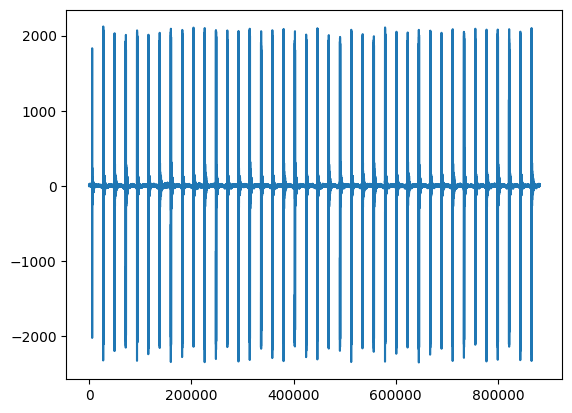

In [104]:
record_x = [64, 82, 109, 143, 150, 178, 232]
record_y = [40, 399, 76, 296, 185, 439, 275]

filename =[]

for i in range(len(record_x)):
    real_x = record_x[i] 
    real_y = record_y[i]
    filename.append("files/student_recording/record_x" + str(real_x) + "_y" + str( real_y) + ".wav")


Fs, recording = wavfile.read(filename[0])
plt.plot(recording[:,0])

## Background Knowledge

In the previous course lab (??@B update), you developed algorithms for channel estimation for 2 microphone signals, both receiving a beacon (training) signal. In the present module, we extend this to 5 microphones and use this to locate the car.

The channel estimation problem is the following: Suppose we transmit a known signal $x[n]$ over a communication channel, and measure the result $y[n]$.  The channel acts as a
filter, which we will assume to be linear and time-invariant.
Therefore, the measured signal is a convolution of the transmitted
signal by the channel impulse response $h[n]$, such that
$y[n] = h[n] \ast x[n]$.  Knowing the transmitted signal $x[n]$, can
we recover the impulse response of the communication channel from
$y[n]$?  This is essentially an inversion problem.


To estimate $h[n]$, three alternative algorithms were described:
- __ch1__ Deconvolution in the time domain: Involves matrix inversion. It is computationally complex and requires lots of memory (easily more than what the available PCs can handle).

- __ch2__ The matched filter: Avoids the matrix inversion. It is equal to computing the cross-correlation of
$y[n]$ with $x[n]$. As cross-correlation is equivalent to a convolution with a reverse signal $x[−n]$, it can be computed efficiently using the FFT. The resulting channel estimate is equal to the true
channel convolved with the autocorrelation of the pulse, $x[n] ∗ x[−n]$. Therefore, its performance
heavily depends on having the correct (i.e., accurate) “reference” or “training” signal to correlate
your measurements with, and the signal should have good autocorrelation properties: $x[n] ∗ x[−n]$
should be close to a delta spike. Large sidelobes will lead to confusion.
- __ch3__ Deconvolution in the frequency domain: Involves the FFT. It computes the same channel as via
deconvolution in the time domain but is much more efficient: convolution in time becomes point-
wise multiplication in frequency, hence for deconvolution in the frequency domain, we only need
a pointwise division, followed by an IFFT to obtain the time-domain channel impulse response.

```{admonition} Note

FFT and IFFT lead to periodicities (the result is cyclic, and samples $x[n]$ at negative time reappear
at the “large n” part of the signal). Since this method is similar to ch1 (but much more efficient),
you can view this method as a matched filter, followed by a correction step that “inverts” the effect
of the autocorrelation of the transmit pulse. However, since we should not divide by zero, you will
also need to implement a “threshold” to set non-invertible or very small frequency coefficients of
$x[n]$ to zero, which otherwise will lead to noise amplification. The performance depends on this
threshold, which has to be chosen heuristically.

```
It is assumed that you have working algorithms for estimating channel responses. You developed these during the previous labs (??@B). We recommend using __ch3:__ deconvolution in thefrequency domain.

In each case, a reference signal $x[n]$ is required. We recommend using a recording close to the beacon because then $x[n]$ includes the loudspeaker and microphone responses as well. For the pre-made recordings, a high-quality reference is available.


The deconvolution algorithm gives a channel estimate for the beacon path to each microphone. After this, we detect the first incoming path, which, assuming Line of Sight (LOS), corresponds to the propagation delay of the car beacon to each microphone. Unfortunately, we do not know the transmit time, so we only obtain relative propagation delays. If we take the difference of microphone delays, this unknown transmit time is eliminated, so we can obtain time difference of arrival (TDOA) samples for each microphone pair.
In the next sections, we will use these to locate the car.

## Deconvolution ##

The first step is to get your deconvolution algorithm operational and tested. Do these tasks with the given
recordings from Brightspace.

**Task 1**  Using the reference signal provided and the algorithms you developed at the EE2T11 Telecom-
munications A practical, deconvolve the recordings to get the channel impulse response for each
microphone. You will need to segment the received data into individual pulses; for the moment,
you can do that manually. For a few measured locations, plot examples of the segmented data and the deconvolved channels
(e.g., 10 plots per recording: the inputs and outputs of your deconvolution algorithm).

In [105]:
### first copy/paset your channel estimation from the earlier assignment here
def channel(x, y): # this is ch2
        """
        Channel estimation using matched filtering.
        """
        xr = x[::-1]
        h = np.convolve(y, xr, mode='full')  # filter xr with y
        alpha = np.dot(x.T, x)
        hhat = h / alpha
        return abs(hhat)

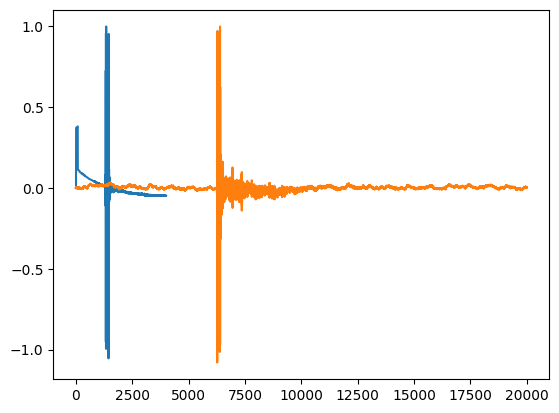

In [107]:
### load, normalize and segment one period of the reference signal
Fs, refSignal = wavfile.read("files/student_recording/reference.wav") # reference signal
refSignal = refSignal[0:4000,0] # one pulse
refSignal = refSignal / max(refSignal) # normalize
plt.plot(refSignal)

# load, normalize and segment one period of the reference signal
Fs, reccordings = wavfile.read("files/student_recording/record_x109_y76.wav")
slice_rec1 = reccordings[:20000,0]
slice_rec1 = slice_rec1 / max(slice_rec1) # normalize
plt.plot(slice_rec1) #one pulse

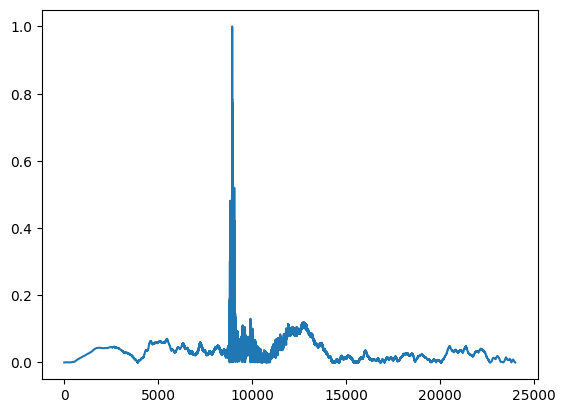

In [108]:
### find the impulse response using the channel estimation 
x = channel(refSignal, slice_rec1)
x = x / max(x)
plt.plot(x)

**Task 2**  From the peaks in the channel estimates, determine the time of arrivals (TOAs) and store these
in a table. Check the accuracies of these estimates. Hint: Obviously, you want to compare these
estimates to your true TOAs. The problem is that the transmission time is unknown, so a direct
comparison is impossible. You can either compare TDOAs (the pairwise differences of TOAs) or
introduce a single unknown parameter (the time of transmission) and develop an error measure
that is insensitive to it. This is harder, but you might find literature on this.

In [109]:
### Task 2: TDOA
### load, normalize, segment and estimate the channel for two different channels as before

## Load two channels
rec1=recording[:, 0]
rec2=recording[:, 2]

## normalize
rec1 = rec1/max(rec1)   # normalize
rec2 = rec2/max(rec2)   # normalize

## segment 
slice_x = rec1[:20000]
slice_y = rec2[:20000]

## estimate the impulse response
x = ch2(refSignal, slice_x)
x = x / max(x)
y = ch2(refSignal, slice_y)
y = y / max(y)

## find the peak location
x_index = np.argmax(x)
y_index = np.argmax(y)

## find the time difference between the two peaks
tdoa_12 = (y_index - x_index) / Fs

## find the distance between the two peaks
dist_12 =  tdoa_12* 343

## print results
print(tdoa_12,dist_12)

0.015646258503401362 5.366666666666667


**Task 3**  Once you are satisfied with the performance of the basic algorithm, extend your code with ways
to automatically segment the received data and find the beginning of a pulse. Hint: A useful
function is findpeaks, which allows you to implement criteria for finding the first strong peak in
a pulse sequence.

**Task 4** Complete the TDOA function. It should return the time difference between any pairs of micro-
phones. Use this function to find TDOAs between channel 0 and all other 4 recording pairs. Use these resulots to find the time difference between the other pairs as well. 

In [110]:
## task 4
def TDOA(rec1, rec2):

        rec1 = rec1/max(rec1)   # normalize
        rec2 = rec2/max(rec2)   # normalize

        dists = np.zeros(C_repetition) # initialize array for distances
        slice_size = len(rec1) // C_repetition # calculate slice size
        for i in range(C_repetition):
            slice_x = rec1[i*slice_size: i*slice_size+slice_size] 
            slice_y = rec2[i*slice_size: i*slice_size+slice_size]
            x = channel(refSignal, slice_x)
            x = x / max(x)
            y = channel(refSignal, slice_y)
            y = y / max(y)
            x_index, y_index = tdoa(x, y)
            dists[i] = (y_index - x_index) / Fs * 343

        dists = average_of_3_median_values(dists)
        return np.mean(dists)

def tdoa(x, y):

        x_index = np.argmax(x)
        y_index = np.argmax(y)

        return x_index, y_index

def channel(x, y):
        """
        Channel estimation using matched filtering.
        """
        xr = x[::-1]
        h = np.convolve(y, xr, mode='full')  # filter xr with y
        alpha = np.dot(x.T, x)
        hhat = h / alpha
        return abs(hhat)

def average_of_3_median_values(arr):
        sorted_arr = np.sort(arr)
        n = len(sorted_arr)

        if n % 2 == 0:
            # Even number of elements
            mid1 = n // 2 - 1
            mid2 = n // 2
            mid3 = n // 2 + 1
            three_medians = [sorted_arr[mid1], sorted_arr[mid2], sorted_arr[mid3]]
        else:
            # Odd number of elements
            mid = n // 2
            mid1 = mid - 1
            mid2 = mid
            mid3 = mid + 1
            three_medians = [sorted_arr[mid1], sorted_arr[mid2], sorted_arr[mid3]]

        average = np.mean(three_medians)
        return average

In [111]:
# get the other recordings
Fs, refSignal = wavfile.read("files/student_recording/reference.wav")
refSignal = refSignal[:,0]
refSignal = refSignal / max(refSignal) # normalize
refSignal = refSignal[0:4000]

Fs, recording = wavfile.read("files/student_recording/record_x150_y185.wav")
recording = recording [:200000,:]

C_repetition = 9

D12 = TDOA(recording[:, 0], recording[:, 1])
D13 = TDOA(recording[:, 0], recording[:, 2])
D14 = TDOA(recording[:, 0], recording[:, 3])
D15 = TDOA(recording[:, 0], recording[:, 4])
### @Mano order of 2 and 3 was reversed, shall we ask them to find distance and not time

# Calculate other microphone differences
D23 = (D13 - D12)
D24 = (D14 - D12)
D34 = (D14 - D13)

**Deliverable** In the midterm report, document your algorithms, show examples of measurements/channel
estimates, and include a subsection on testing, showing your findings and accuracies.

As plots, we suggest to show an entire recording, and then one where you zoom in on the short
segment that you give to ch3. Of the resulting channel estimate, show the entire result, and then
zoom in on the interesting part where are the peaks. Remember that for negative delays, the peak
of interest will be at the “large n” part of your estimate.

In [ ]:
## @B add a code block for each section, to complete the taseks, shall we create a class for it?
## Shall we already add the localization module here and ask them to complete it?
## maybe first as seperate function then integrated in the class?

## LOCALIZATION USING TDOA INFORMATION ##

Now we arrive at the main question studied in this module: how can we locate the car using the TDOA
estimates? With 5 microphones, we can compute the TDOAs between all pairs of microphones and
obtain 10 TDOA pairs.
Study Appendix C, (@B update) it shows a basic algorithm to compute the (x, y) location of the car based on the
measured TDOAs. This algorithm can be extended to fit our situation: In our application, we have the
audio beacon on the car at a certain height above the ground (we define this as z = 0), but the microphones
are placed on stands at a different height. You can assume that the height difference between the audio
beacon of the car and the microphones is known.

## Localization algorithm assignments

**Task 1** Develop a test code using Pythagoras’ theorem that takes an (x, y) position as input and calculates
the TDOA that you would observe from this position. This involves calculating the distance from
the given point to each microphone. This will help you debug both your TDOA function and your
`coordinate_2d` function.

**Task 2** 
Using the distsnces estimated previously and the microphone location generate matrix A and b (introduced in appendix C) and use them to find the (x,y) location. Once you are sure it works for a few examples turn it into a function called `coordinate_2d`.

**Deliverable** Document the accuracy of your localization algorithm. Is this acceptable for your appli-
cation? As an illustration, you can also plot the room and show the true locations and estimated
locations. For the midterm report, document your algorithm and the results of the tests on simu-
lated and given test data. Also report on the given test data with unknown position: what positions
do you estimate? Finish with a conclusion that summarizes the accuracy that can be expected and
the reliability (i.e., how often it succeeds in finding a reliable location).

In [112]:
# Microphone coordinates
xyMic = np.array([[0, 0], [4.80, 0], [0, 4.80], [4.80, 4.80]])

A = np.array([[2 * (xyMic[1, 0] - xyMic[0, 0]), 2 * (xyMic[1, 1] - xyMic[0, 1]), -2 * D12, 0, 0],
                      [2 * (xyMic[2, 0] - xyMic[0, 0]), 2 * (xyMic[2, 1] - xyMic[0, 1]), 0, -2 * D13, 0],
                      [2 * (xyMic[3, 0] - xyMic[0, 0]), 2 * (xyMic[3, 1] - xyMic[0, 1]), 0, 0, -2 * D14],
                      [2 * (xyMic[2, 0] - xyMic[1, 0]), 2 * (xyMic[2, 1] - xyMic[1, 1]), 0, -2 * D23, 0],
                      [2 * (xyMic[3, 0] - xyMic[1, 0]), 2 * (xyMic[3, 1] - xyMic[1, 1]), 0, 0, -2 * D24],
                      [2 * (xyMic[3, 0] - xyMic[2, 0]), 2 * (xyMic[3, 1] - xyMic[2, 1]), 0, 0, -2 * D34]
                      ])

b = np.array([(pow(D12, 2) - pow(np.linalg.norm(xyMic[0, :]), 2) + pow(np.linalg.norm(xyMic[1, :]), 2)),
                      (pow(D13, 2) - pow(np.linalg.norm(xyMic[0, :]), 2) + pow(np.linalg.norm(xyMic[2, :]), 2)),
                      (pow(D14, 2) - pow(np.linalg.norm(xyMic[0, :]), 2) + pow(np.linalg.norm(xyMic[3, :]), 2)),
                      (pow(D23, 2) - pow(np.linalg.norm(xyMic[1, :]), 2) + pow(np.linalg.norm(xyMic[2, :]), 2)),
                      (pow(D24, 2) - pow(np.linalg.norm(xyMic[1, :]), 2) + pow(np.linalg.norm(xyMic[3, :]), 2)),
                      (pow(D34, 2) - pow(np.linalg.norm(xyMic[2, :]), 2) + pow(np.linalg.norm(xyMic[3, :]), 2))
                      ])

y = np.linalg.inv(A.T @ A) @ A.T @ b
print(y[0:2])

[2.38336496 2.68930863]


## Localization Class

Now, it is time to start setting up a processing pipeline by putting everything together. The localization class you will develop will take a 5-channel recording of input and return the x and y coordinates of the car. Below is an outline of a localization class you could use. Note that this is to help you get started, and you will have to add methods and logic yourself. Look at the comments inside of the class for an explanation. Once you are done, you can copy this class in a seperate file and import and use it in other modules.

In [ ]:
class Localization:
    def __init__(self, recording, debug=False):
    # Store the recordings
    # Load the reference signal from memory
    # x_car, y_car = self.localization()

    def localization(self):
    # Split each recording into individual pulses
    # Calculate TDOA between different microphone pairs
    # Run the coordinate_2d using the calculated TDOAs

    def TDOA(self, rec1, rec2):
    # Calculate channel estimation of each recording using ch2 or ch3
    # Calculate TDOA between two recordings based on peaks
    # in the channel estimate

    @staticmethod
    def channel(x, y):
    # Channel estimation

    def coordinate_2d(self, D12, D13, D14):
    # Calculate 2D coordinates based on TDOA measurements
    # using the linear algebra given before

if __name__ == "__main__":
# Main block for testing
# Read the .wav file
# Localize the sound source
# Present the results

In [ ]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.io import wavfile
import time
import matplotlib.pyplot as plt
import scipy

class Localization:

    def __init__(self, recording, debug=False):

        self.debug = debug
        self.recording = recording

        self.Fs, self.refSignal = wavfile.read("Recordings/refSignal.wav") # reference signal
        self.refSignal = self.refSignal / max(self.refSignal) # normalize
        self.refSignal = self.refSignal[0:1500] # cut to one pulse (maybe 4000 is better)

        self.bitcode = 'F3824D4D'  # transmitted bits [-]
        self.F_carrier = 5000  # carrier frequency [Hz]
        self.F_bit = 2000  # bit frequency [Hz]
        self.C_repetition = 20  # repetition count [-]

        self.xyCar = [481, 481] # car location [m]

        self.localization()

    def localization(self):
        """
        Perform localization based on time difference of arrival (TDOA) measurements.

        This method calculates the TDOA between the recorded audio signals from different microphones
        and uses these measurements to estimate the coordinates of the source of the sound.

        Returns:
            None
        """

        D12 = self.TDOA(self.recording[:, 0], self.recording[:, 1])
        D13 = self.TDOA(self.recording[:, 0], self.recording[:, 3])
        D14 = self.TDOA(self.recording[:, 0], self.recording[:, 2])
        D15 = self.TDOA(self.recording[:, 0], self.recording[:, 4])

        if self.debug:
            print(f"D12: {D12}")
            print(f"D13: {D13}")
            print(f"D14: {D14}")
            print(f"D15: {D15}")

        self.xyCar = self.coordinate_2d(D12, D13, D14)
        print(f"Location of car: {self.xyCar}")

    def TDOA(self, rec1, rec2):

        rec1 = rec1/max(rec1)   # normalize
        rec2 = rec2/max(rec2)   # normalize

        if self.debug:
            plt.plot(range(len(rec1)), rec1)
            plt.plot(range(len(rec2)), rec2)
            plt.title("Recordings")
            plt.show()

        dists = np.zeros(self.C_repetition) # initialize array for distances
        slice_size = len(rec1) // self.C_repetition # calculate slice size
        for i in range(self.C_repetition):
            slice_x = rec1[i*slice_size: i*slice_size+slice_size] 
            slice_y = rec2[i*slice_size: i*slice_size+slice_size]
            x = self.ch2(self.refSignal, slice_x)
            x = x / max(x)
            y = self.ch2(self.refSignal, slice_y)
            y = y / max(y)
            x_index, y_index = self.tdoa(x, y)
            dists[i] = (y_index - x_index) / self.Fs * 343

            if i < 3 and self.debug:
                plt.plot(range(len(x)), x, alpha=0.3)
                plt.plot(range(len(y)), y, alpha=0.3)
                plt.title(f"Channel estimate {(y_index - x_index) / self.Fs * 343}")
                plt.scatter(x_index, x[x_index], c='blue', marker='o', alpha=0.5)
                plt.scatter(y_index, y[y_index], c='red', marker='o', alpha=0.5)
                plt.show()
                print((y_index - x_index) / self.Fs * 343)

        dists = self.average_of_3_median_values(dists)
        return np.mean(dists)

    def tdoa(self, x, y):

        x_index = np.argmax(x)
        y_index = np.argmax(y)

        return x_index, y_index

    @staticmethod
    def ch2(x, y):
        """
        Channel estimation using matched filtering.
        """
        xr = x[::-1]
        h = np.convolve(y, xr, mode='full')  # filter xr with y
        alpha = np.dot(x.T, x)
        hhat = h / alpha
        return abs(hhat)

    def average_of_3_median_values(self, arr):
        sorted_arr = np.sort(arr)
        n = len(sorted_arr)

        if n % 2 == 0:
            # Even number of elements
            mid1 = n // 2 - 1
            mid2 = n // 2
            mid3 = n // 2 + 1
            three_medians = [sorted_arr[mid1], sorted_arr[mid2], sorted_arr[mid3]]
        else:
            # Odd number of elements
            mid = n // 2
            mid1 = mid - 1
            mid2 = mid
            mid3 = mid + 1
            three_medians = [sorted_arr[mid1], sorted_arr[mid2], sorted_arr[mid3]]

        average = np.mean(three_medians)
        return average

    def coordinate_2d(self, D12, D13, D14):
        # Calculate other microphone differences
        D23 = (D13 - D12)
        D24 = (D14 - D12)
        D34 = (D14 - D13)

        # Microphone coordinates
        xyMic = np.array([[0, 0], [4.80, 0], [0, 4.80], [4.80, 4.80]])

        A = np.array([[2 * (xyMic[1, 0] - xyMic[0, 0]), 2 * (xyMic[1, 1] - xyMic[0, 1]), -2 * D12, 0, 0],
                      [2 * (xyMic[2, 0] - xyMic[0, 0]), 2 * (xyMic[2, 1] - xyMic[0, 1]), 0, -2 * D13, 0],
                      [2 * (xyMic[3, 0] - xyMic[0, 0]), 2 * (xyMic[3, 1] - xyMic[0, 1]), 0, 0, -2 * D14],
                      [2 * (xyMic[2, 0] - xyMic[1, 0]), 2 * (xyMic[2, 1] - xyMic[1, 1]), 0, -2 * D23, 0],
                      [2 * (xyMic[3, 0] - xyMic[1, 0]), 2 * (xyMic[3, 1] - xyMic[1, 1]), 0, 0, -2 * D24],
                      [2 * (xyMic[3, 0] - xyMic[2, 0]), 2 * (xyMic[3, 1] - xyMic[2, 1]), 0, 0, -2 * D34]
                      ])

        b = np.array([(pow(D12, 2) - pow(np.linalg.norm(xyMic[0, :]), 2) + pow(np.linalg.norm(xyMic[1, :]), 2)),
                      (pow(D13, 2) - pow(np.linalg.norm(xyMic[0, :]), 2) + pow(np.linalg.norm(xyMic[2, :]), 2)),
                      (pow(D14, 2) - pow(np.linalg.norm(xyMic[0, :]), 2) + pow(np.linalg.norm(xyMic[3, :]), 2)),
                      (pow(D23, 2) - pow(np.linalg.norm(xyMic[1, :]), 2) + pow(np.linalg.norm(xyMic[2, :]), 2)),
                      (pow(D24, 2) - pow(np.linalg.norm(xyMic[1, :]), 2) + pow(np.linalg.norm(xyMic[3, :]), 2)),
                      (pow(D34, 2) - pow(np.linalg.norm(xyMic[2, :]), 2) + pow(np.linalg.norm(xyMic[3, :]), 2))
                      ])

        y = np.linalg.inv(A.T @ A) @ A.T @ b
        return y[0:2]

if __name__ == "__main__":
    start_t = time.perf_counter()

    # Read the .wav file
    Fs, recording = wavfile.read("Recordings/recording349152.wav")

    # Localize the sound source
    loc = Localization(recording, True)

    stop_t = time.perf_counter()
    print(f"Total time: {stop_t - start_t:0.4f}")
    print(f"Location of car: {loc.xyCar}")

## Optional Extension

If you finish the basic assignment quickly and want to challenge yourself further, try adding additional
functionality to the program. For example, you could look at one of the following aspects:

- The current set of linear equations in Appendix C does not consider the height difference between
the microphones and the car. This leads to a slight offset. Adding in the 5th microphone at a
different height can fix this. Use logic and maths to adjust the matrices to accommodate this extra
microphone and the z-axis.
- The provided method in Appendix C is simple but unreliable for certain locations. What happens
if the distance of the car to two microphones is equal (symmetry positions)? In that case, one
column of the matrix that you try to invert is zero. During System Integration, you can search the
literature and try to implement more advanced algorithms, e.g.,
    - Stephen Bancroft, “An algebraic solution of the GSP equations”, IEEE Transactions on
Aerospace and Electronic Systems, vol.21, no.7, pp.56-59, January 1985.
    - Amir Beck, Petre Stoica, and Jian Li, “Exact and Approximate Solutions of Source Localiza-
    tion Problems”, IEEE Transactions on Signal Processing, vol.56, no.5, pp. 1770-1778, May
    2008.
    The literature on this topic is actually very rich. The latter paper gives a good overview. You can
also try to solve for the true solution using the nonlinear Least Squares optimization toolboxes.
In previous years, some students have implemented a grid search, in which the room is partitioned
into a dense grid of possible positions, and each location is tested against the TDOA data to find
the best fit. You could do this in two steps: first coarse, then fine.

- Try a different channel estimation function. 
- Apply filters to detect outliers and average the result of multiple pulses.

If you have completed this successfully, you can start integrating and estimating the car’s location. Start
by finding a set of suitable parameters for your audio beacon. Communicate with the other part of your
team. They should be finalizing the microphone recording code. If this is not the case, work together to
complete the code. It is better to complete the mid-term first with well-tested code and then to continue
working on more functionality. Otherwise, you will spend all your time trying to integrate all the loose
bits of code in the end.

## AFTER THE MIDTERM: REFERENCE SIGNAL AND INTEGRATION ##
(@B @mano @mehrdad how to be more clear about htis division, is it mandatory? it's so open-ended, should we add some more guidlines for the students?)

As you will remember from your EE2T11 Telecommunications A practical in Q3 (?? @B update), you must have a clean
reference signal to get a good channel/impulse response estimate, which you can then use to deconvolve
the recordings you make to locate KITT. Getting this clean reference is what you will do here since it
entails more than just simulating the OOK code, as you must also consider the microphone’s channel
and the beacon’s behavior.
This reference is crucial in finding the channel’s impulse response between the beacon and the micro-
phone and, consequently, in finding the TDOA to locate KITT within the field.
Appendix A reminds you of the beacon signal parameters that are used to generate the beacon signal;
they are similar to what you saw in the EE2T11 practical.

## Reference Signal Assessment

**Task 1** Determine a good bit code to transmit using KITT’s beacon, for this consider its autocorrelation
function. You want a strong peak for the 0-lag of the autocorrelation but as low as possible for any
other lag.
*Hint:* Suitable codes could be randomly generated, or you can try some optimal codes (check
communication theory literature for “gold codes”).

**Task 2** Determine the other parameters for KITT. What is a good carrier frequency to use? What is a good bit frequency? A perfect repetition count is not yet required as this will depend on your later script but do make sure that the full code can be transmitted and that it can be recorded on all microphones within the same recording window.
*Hint:* You could try to find a datasheet of the microphones to determine a good carrier frequency;
it depends on the sensitivity of the loudspeaker and the microphones. More reliably: you can measure the response of the system for various carrier frequencies (e.g., spaced by 1000 Hz) and make a plot of the amplitude response. You can then later select a carrier frequency with maximal
response

**Task 3** Record the bit-code transmitted over KITT’s beacon with your new parameters. Keep the micro- phone very close to KITT’s beacon to get a recording that is as clear as possible, but do make sure
to avoid clipping. Look at the waveform you get from this recording. Can you think of a way to reduce the noise? If you cannot develop a way to do this, ask a TA or other instructors.

**Task 4** The recording you made with the microphone close to the beacon can be the reference signal.
Look at the waveform of the reference and look at its autocorrelation. What do you see? Compare this to the “ideal” OOK and autocorrelation from **Task 1**.

**Task 5** Clean up your recording and strip “zero intervals” away such that only a clean recording of a single pulse remains.

**Deliverable** Show the autocorrelations and plots you made in the final report and comment on what you see. Explain your answers to the questions, what led you to those answers, and explain your choices.

## Integration KITT assignments
(@B @mano @mehrdad  should we add some more guidlines for the students? more methods to kiit or localization class)

**Task 1** Record several transmissions from KITT’s beacon with KITT at various locations in the field.
Store these recordings and KITT’s (x, y) coordinates.

**Task 2** Using the reference signal you developed previously and the algorithms you developed for the mid-term, estimate the locations using these recordings, off-line.

**Task 3** Do the same as in Task 2, but now couple the location algorithm and the recording code. Assuming you solve the “blocking recording” issue, you should now be able to drive KITT around and locate it all in realtime.

**Task 4** Try to add time-stamp information. By the time you calculated your position, KITT has already moved. And note that in your recording, you look for a pulse, which is also from some time ago.
Luckily, you can estimate most of these delays. Augmenting your location estimates with time stamps might be very helpful for the controller that your team will build next, in particular if you
intend to drive fast.

**Deliverable** Document this process and reflect on your findings and accuracies.

## Mid-term assessment 3 and report

In week 4, you will have to showcase the functionality of your localization script to your assigned TA.
You should demonstrate proper localization of the car on the 3 recordings with unknown coordinates.
After you pass this assessment, you are ready to document your results in your midterm report. A
detailed report is required, covering the approach, implementation, testing and results, as mentioned
above. Please review Chapter 7 for guidelines.

__Preparation__
- Read this module
- Review your TDOA and deconvolution algorithms from the EE2T11 Telecommunications A(??@B update) practical
- Study Appendix C (??@B update)
- Make sure your Python IDE is ready to go!


__Time duration__ Four lab sessions and four preparation/reporting sessions at home
    
__What is needed:__ The following
- KITT
- Laptop/PC running Python
- Your TDOA and deconvolution algorithms from EE2T11 Telecommunications A
- On Brightspace: 7+3 pre-recorded audio recordings.
